<a href="https://colab.research.google.com/github/JonathanMairena/Otoscope-Automation-and-Enhancement/blob/main/otoai_classifier_vgg_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load and preprocess data 

In [ ]:
## access images in drive 
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Senior\ Design/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Senior Design


In [ ]:
## assign directories for training and validation 
import os

base_dir = '/content/drive/My Drive/Senior Design/database_custom_split/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training abnormal pictures
train_abnormal_dir = os.path.join(train_dir, 'Abnormal')

# Directory with our training normal pictures
train_normal_dir = os.path.join(train_dir, 'Normal')

# Directory with our validation abnormal pictures
validation_abnormal_dir = os.path.join(validation_dir, 'Abnormal')

# Directory with our validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'Normal')

# Check number of training and test images 
print('total training abnormal images:', len(os.listdir(train_abnormal_dir)))
print('total training normal images:', len(os.listdir(train_normal_dir)))
print('total validation abnormal images:', len(os.listdir(validation_abnormal_dir)))
print('total validation normal images:', len(os.listdir(validation_normal_dir)))


total training abnormal images: 847
total training normal images: 637
total validation abnormal images: 361
total validation normal images: 271


In [ ]:
## data augmentation, flow train + validation images 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=30,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary')


Found 1484 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


#ConvNet 

In [ ]:
## Design architecture 

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# base model (pre-trained VGG-16)
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(150, 150, 3))) 

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# input for headmodel is features extracted from pre-trained VGG-16 
headModel = baseModel.output

# Flatten the output layer to 1 dimension
headModel = Flatten(name="flatten")(headModel)

# Add a fully connected layer with 512 hidden units and ReLU activation
headModel = Dense(512, activation="relu")(headModel)

# Add a dropout rate of 0.5
headModel = Dropout(0.5)(headModel)

# Add a final sigmoid layer for classification
headModel = Dense(1, activation="sigmoid")(headModel)

# Configure model 
model = Model(inputs=baseModel.input, outputs=headModel)

# Configure and compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])


In [ ]:
## train network
with tf.device('/device:GPU:0'):  
  history = model.fit_generator(
        train_generator,
        steps_per_epoch=49,
        epochs=300,
        validation_data=validation_generator,
        validation_steps=21,
        verbose=2)
  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
49/49 - 24s - loss: 0.6306 - acc: 0.6520 - val_loss: 0.5194 - val_acc: 0.6603
Epoch 2/300
49/49 - 23s - loss: 0.5677 - acc: 0.6754 - val_loss: 0.5148 - val_acc: 0.6381
Epoch 3/300
49/49 - 23s - loss: 0.5392 - acc: 0.6946 - val_loss: 0.4585 - val_acc: 0.7937
Epoch 4/300
49/49 - 23s - loss: 0.5183 - acc: 0.7180 - val_loss: 0.4464 - val_acc: 0.7889
Epoch 5/300
49/49 - 23s - loss: 0.5044 - acc: 0.7256 - val_loss: 0.4336 - val_acc: 0.8127
Epoch 6/300
49/49 - 23s - loss: 0.4960 - acc: 0.7306 - val_loss: 0.4234 - val_acc: 0.8000
Epoch 7/300
49/49 - 23s - loss: 0.4870 - acc: 0.7345 - val_loss: 0.4155 - val_acc: 0.8032
Epoch 8/300
49/49 - 23s - loss: 0.4946 - acc: 0.7331 - val_loss: 0.4212 - val_acc: 0.8000
Epoch 9/300
49/49 - 23s - loss: 0.4761 - acc: 0.7517 - val_loss: 0.4170 - val_acc: 0.7984
Epoch 10/300
49/49 - 23s - loss: 0.4701 - acc: 0.7462 - val_loss: 0.4195 - val_acc: 0.7984
Epoch 11/300
49/49 - 23s - loss: 0.4681 - acc: 0.7613 - val_loss: 0.4117 - val_acc: 0.8000
Epoch 12

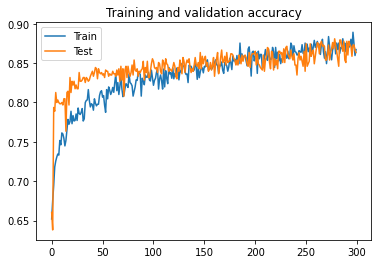

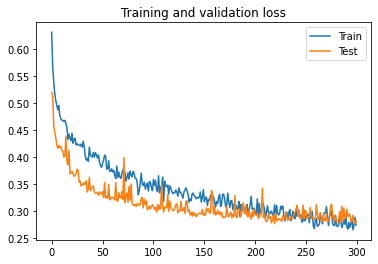

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Train')
plt.plot(epochs, val_acc, label='Test')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Train')
plt.plot(epochs, val_loss,label='Test')
plt.title('Training and validation loss')
plt.legend()
